# Analisa Product Olist Eccomerce

## Data Loading

In [1]:

# Import modules
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the SQLite database
db_path = 'olist.db'
conn = sqlite3.connect(db_path)

# Fetch the list of tables in the database
def get_result(conn, table_name):
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    return df


In [2]:
# Fetch data from the specified tables and store them in individual DataFrames
df_order_payments = get_result(conn, 'olist_order_payments_dataset')
df_orders = get_result(conn, 'olist_order_dataset')
df_order_items = get_result(conn, 'olist_order_items_dataset')
df_products = get_result(conn, 'olist_products_dataset')

In [3]:
# Drop the index columns from each DataFrame, if they exist to prevent issues with joining the tables
for df in [df_order_payments, df_orders, df_order_items, df_products]:
    if 'index' in df.columns:
        df.drop(columns=['index'], inplace=True)

## Data Joining

### Join Tables

In [4]:
# Join the DataFrames
joined_df = pd.merge(df_order_payments, df_orders, on='order_id', how='inner')
joined_df = pd.merge(joined_df, df_order_items, on='order_id', how='inner')
joined_df = pd.merge(joined_df, df_products, on='product_id', how='inner')

joined_df.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,117601,117601.000000,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,...,117601.000000,117601.000000,115903,115903.000000,115903.000000,115903.000000,117581.000000,117581.000000,117581.000000,117581.000000
unique,98665,NaN,4,NaN,NaN,98665,7,98111,90173,81016,...,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,credit_card,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,...,NaN,NaN,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,63,NaN,86769,NaN,NaN,63,115035,63,63,63,...,NaN,NaN,11823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,NaN,NaN,NaN,NaN,NaN,...,120.824783,20.045990,NaN,48.767590,786.950855,2.207881,2114.309497,30.257235,16.630306,23.068574
std,NaN,0.726692,NaN,2.774223,267.592290,NaN,NaN,NaN,NaN,NaN,...,184.479323,15.861315,NaN,10.035011,653.036231,1.719531,3788.798201,16.190920,13.458952,11.748468
min,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.850000,0.000000,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,NaN,NaN,NaN,NaN,NaN,...,39.900000,13.080000,NaN,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,1.000000,NaN,2.000000,108.210000,NaN,NaN,NaN,NaN,NaN,...,74.900000,16.290000,NaN,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,1.000000,NaN,4.000000,189.260000,NaN,NaN,NaN,NaN,NaN,...,134.900000,21.190000,NaN,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000


## Data Cleaning

### Data Quality Check

In [5]:
# Checking for NaN rows
joined_df_nan = joined_df.isna().sum()
joined_df_nan

order_id                            0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1698
product_name_lenght              1698
product_description_lenght       1698
product_photos_qty               1698
product_weight_g                   20
product_length_cm                  20
product_height_cm                  20
product_width_cm                   20
dtype: int64

In [6]:
# Checking for Duplicated rows
joined_df_dup = joined_df.duplicated().sum()
joined_df_dup

0

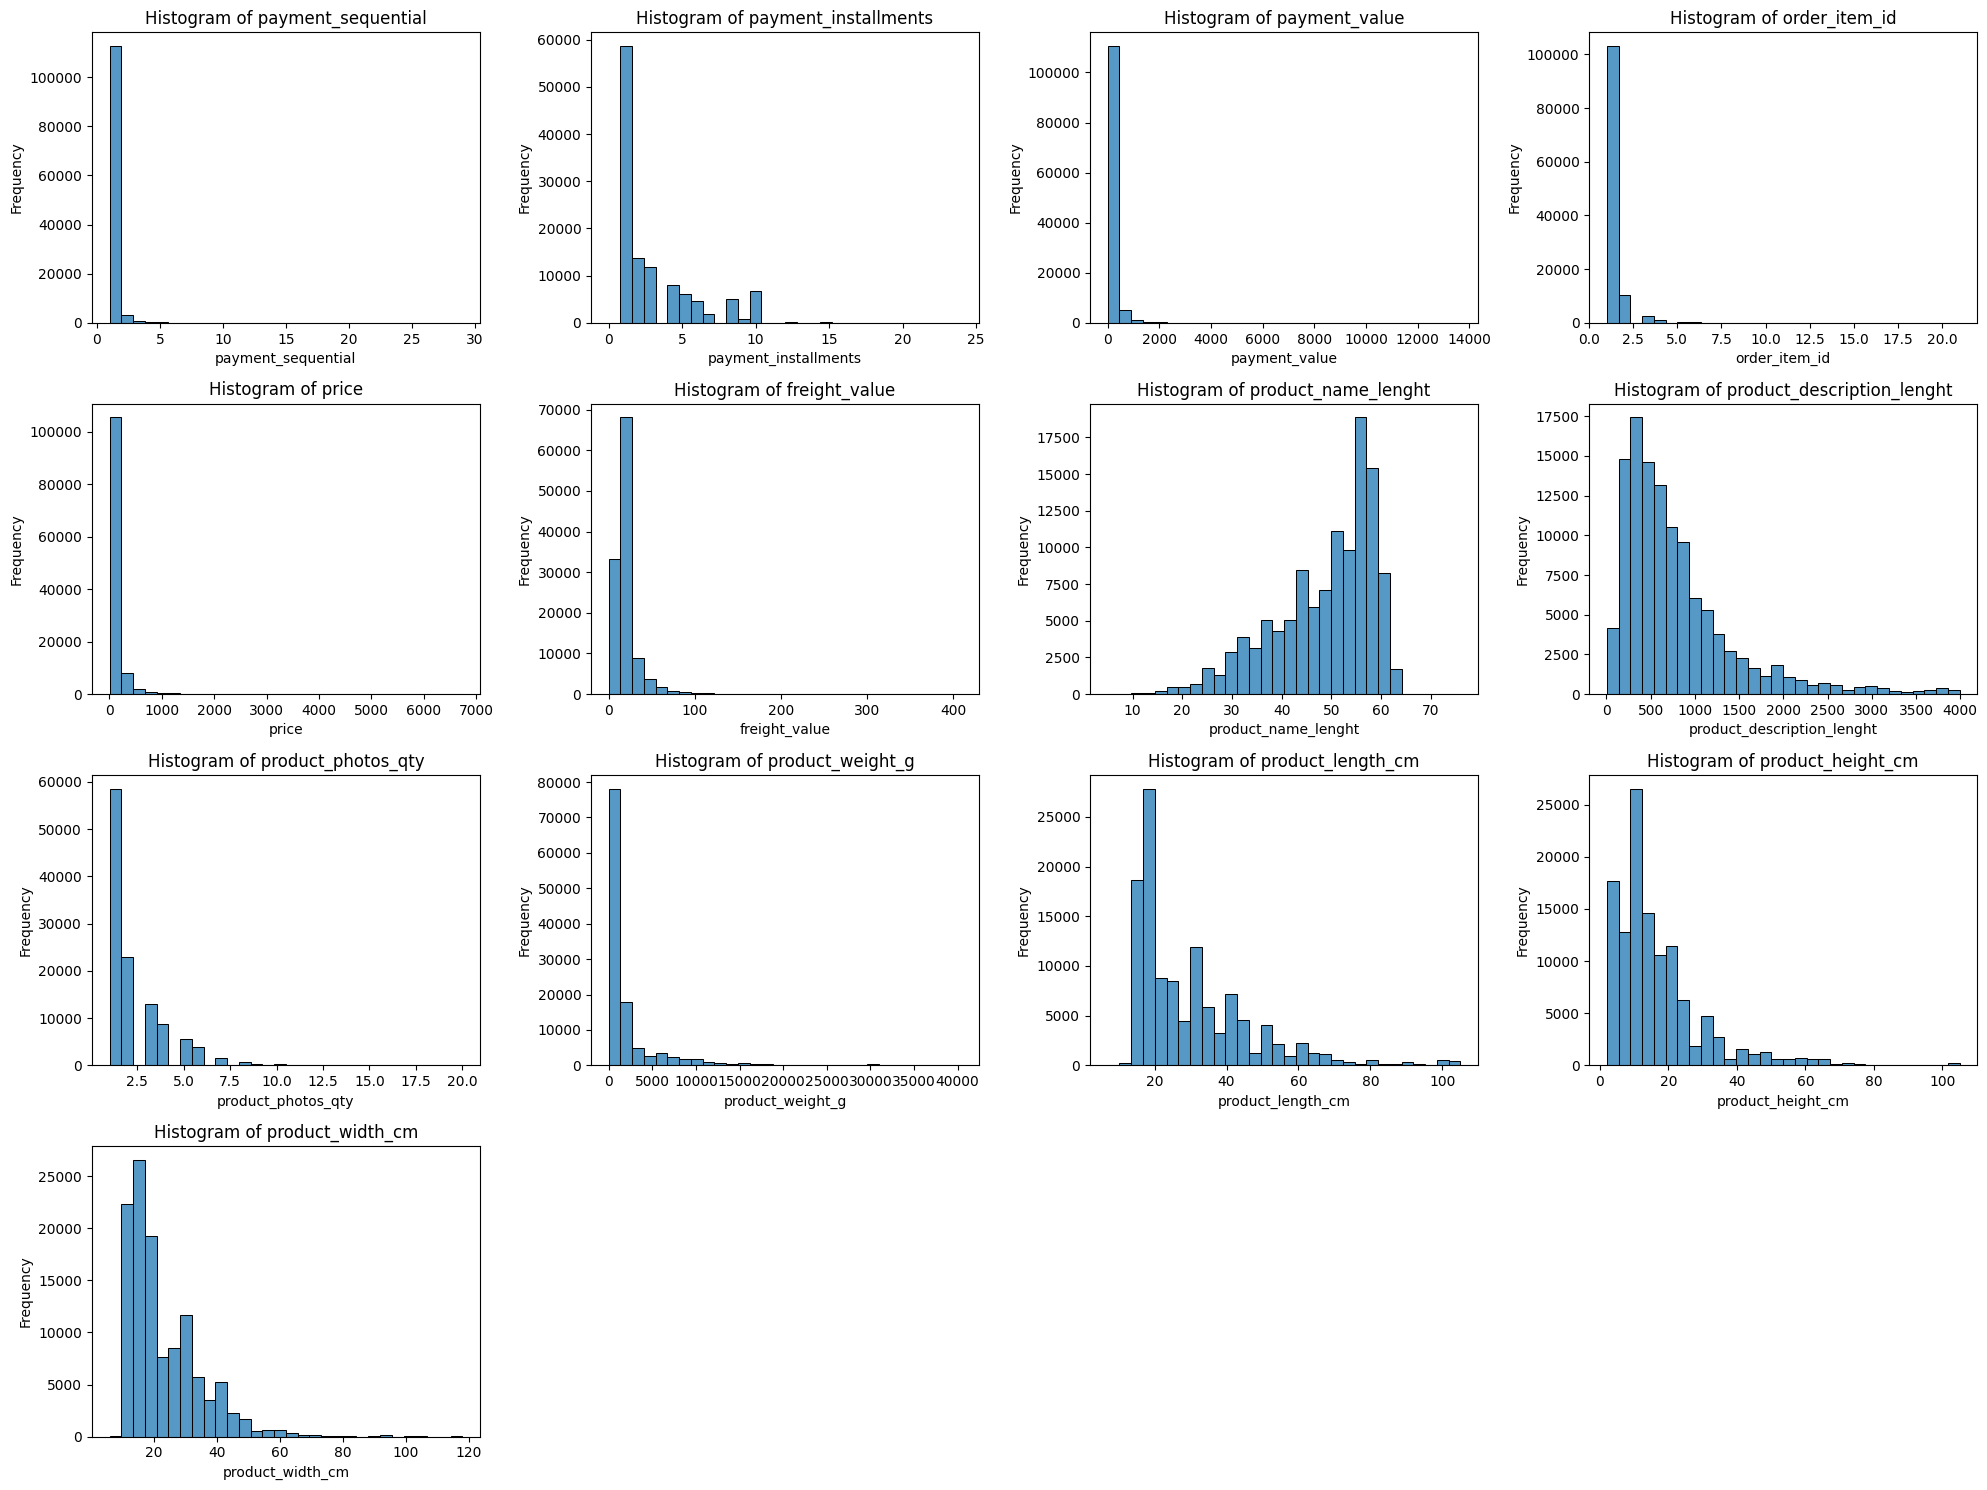

In [7]:
# Checking for Outliers
# Checking only for numerical collumns
numerical_columns_df = joined_df.select_dtypes(include=['number']).columns

# Set up the figure size for the subplots
plt.figure(figsize=(20, 15))

# Loop through numerical columns to create histograms
for i, col in enumerate(numerical_columns_df, 1):
    plt.subplot(4, 4, i)
    sns.histplot(joined_df[col], bins=30, kde=False)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()


In [8]:
# Checking for non standard date formats
# Extract one example value from each date column
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
date_example_values = {col: joined_df[col].dropna().iloc[0] for col in date_columns}
date_example_values

{'order_purchase_timestamp': '2018-04-25 22:01:49',
 'order_approved_at': '2018-04-25 22:15:09',
 'order_delivered_carrier_date': '2018-05-02 15:20:00',
 'order_delivered_customer_date': '2018-05-09 17:36:51',
 'order_estimated_delivery_date': '2018-05-22 00:00:00'}

### Removing Missing Values

In [9]:

# Remove missing values
cleaned_df = joined_df.dropna()
cleaned_df.describe(include='all')


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,113390,113390.000000,113390,113390.000000,113390.000000,113390,113390,113390,113390,113390,...,113390.000000,113390.000000,113390,113390.000000,113390.000000,113390.000000,113390.000000,113390.000000,113390.000000,113390.000000
unique,95128,NaN,4,NaN,NaN,95128,2,94624,87124,78920,...,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,credit_card,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,...,NaN,NaN,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,63,NaN,83706,NaN,NaN,63,113383,63,63,63,...,NaN,NaN,11649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.089937,NaN,2.942367,172.241850,NaN,NaN,NaN,NaN,NaN,...,120.184057,20.023985,NaN,48.801755,785.793059,2.209375,2110.641917,30.281665,16.618635,23.099427
std,NaN,0.682057,NaN,2.777802,266.596347,NaN,NaN,NaN,NaN,NaN,...,182.761548,15.752500,NaN,10.018253,650.986313,1.720293,3770.379971,16.160708,13.447915,11.740315
min,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.850000,0.000000,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,1.000000,NaN,1.000000,61.000000,NaN,NaN,NaN,NaN,NaN,...,39.900000,13.080000,NaN,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,1.000000,NaN,2.000000,108.140000,NaN,NaN,NaN,NaN,NaN,...,74.900000,16.320000,NaN,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,1.000000,NaN,4.000000,189.370000,NaN,NaN,NaN,NaN,NaN,...,133.732500,21.200000,NaN,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000


## Analysis

C:\Users\Keembo\AppData\Local\Temp\ipykernel_260292\166042695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['order_purchase_year_month'] = pd.to_datetime(cleaned_df['order_purchase_timestamp']).dt.to_period('M')


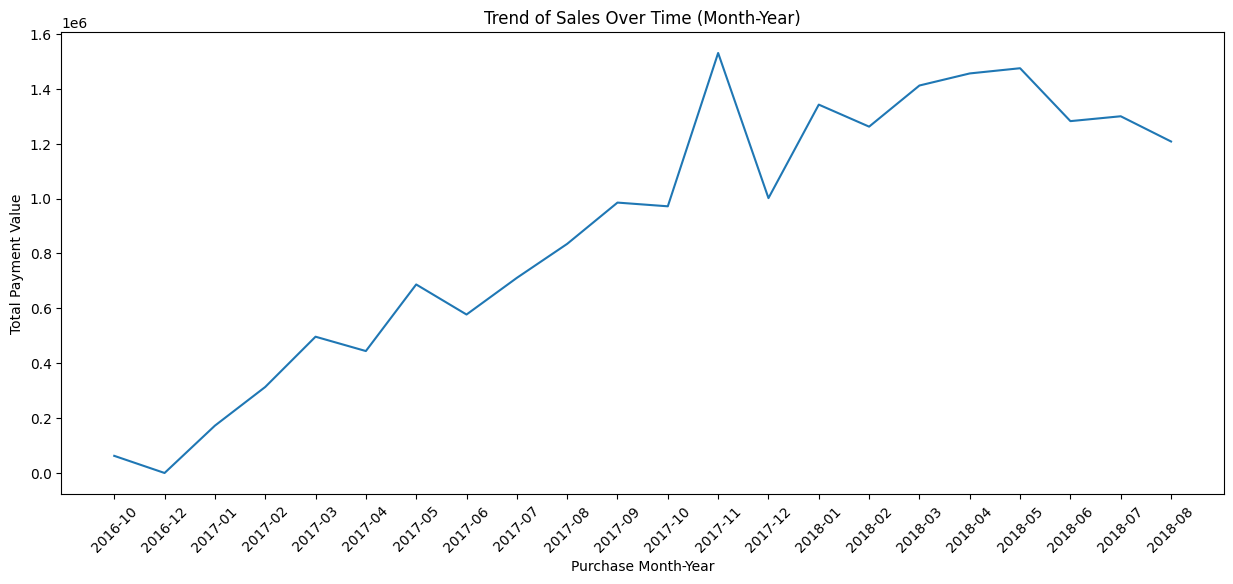

In [10]:
# Analysis 1
# Convert 'order_purchase_timestamp' to datetime and extract just the year and month for aggregation
cleaned_df['order_purchase_year_month'] = pd.to_datetime(cleaned_df['order_purchase_timestamp']).dt.to_period('M')

# Aggregate the sales data by year-month
sales_trend_year_month = cleaned_df.groupby('order_purchase_year_month')['payment_value'].sum().reset_index()
sales_trend_year_month['order_purchase_year_month'] = sales_trend_year_month['order_purchase_year_month'].astype(str)

# Plotting by month-year
plt.figure(figsize=(15, 6))
sns.lineplot(x='order_purchase_year_month', y='payment_value', data=sales_trend_year_month)
plt.title('Trend of Sales Over Time (Month-Year)')
plt.xlabel('Purchase Month-Year')
plt.ylabel('Total Payment Value')
plt.xticks(rotation=45)
plt.show()


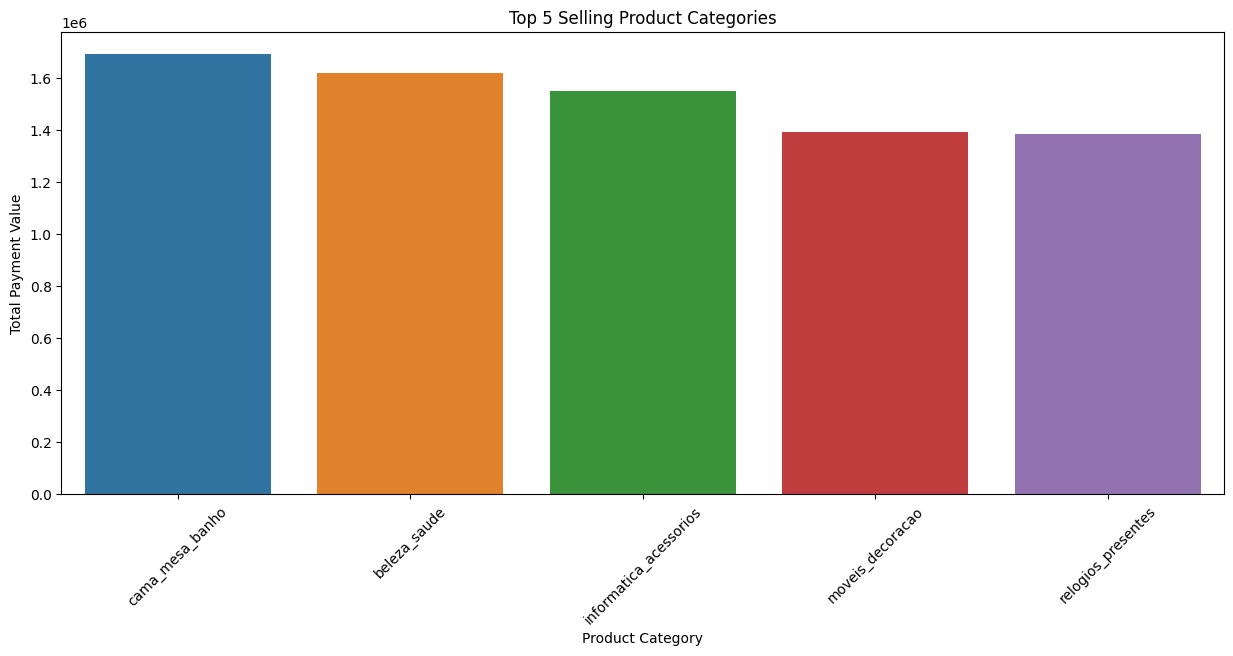

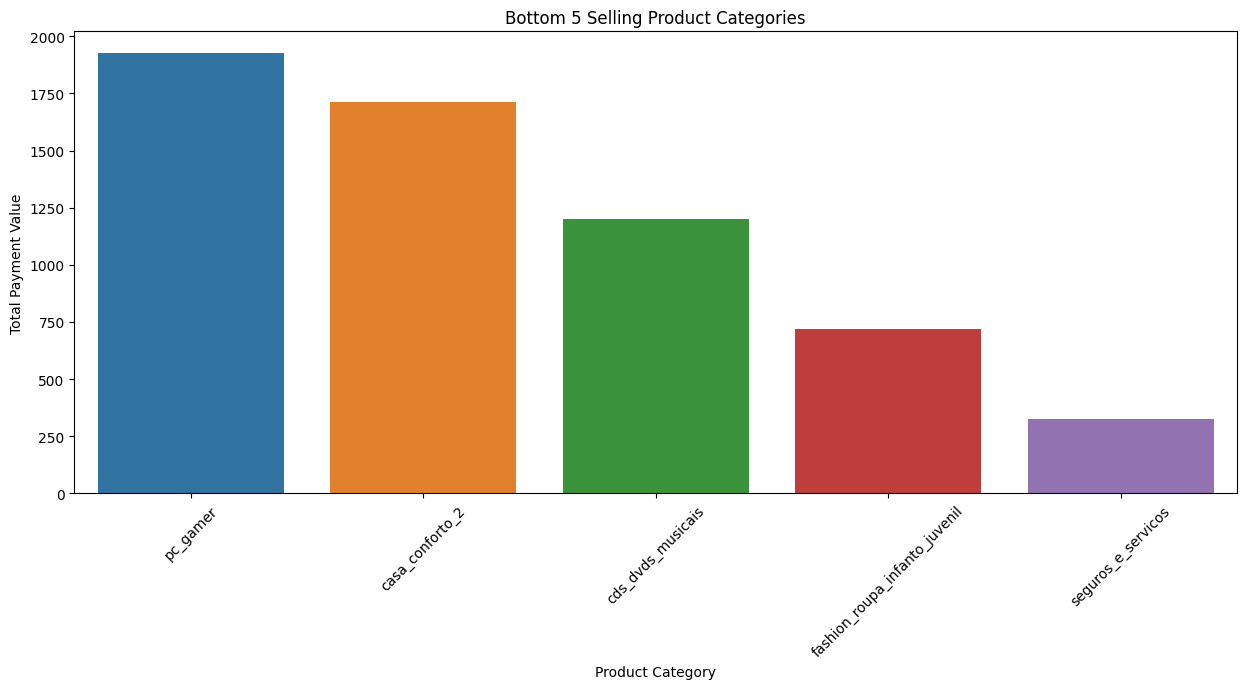

In [11]:
# Analysis 2
# Aggregate the sales data by product category
category_sales = cleaned_df.groupby('product_category_name')['payment_value'].sum().reset_index().sort_values(by='payment_value', ascending=False)

# Top 5 selling categories
top_5_categories = category_sales.head(5)

# Bottom 5 selling categories
bottom_5_categories = category_sales.tail(5)

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value', data=top_5_categories)
plt.title('Top 5 Selling Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Total Payment Value')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value', data=bottom_5_categories)
plt.title('Bottom 5 Selling Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Total Payment Value')
plt.xticks(rotation=45)
plt.show()


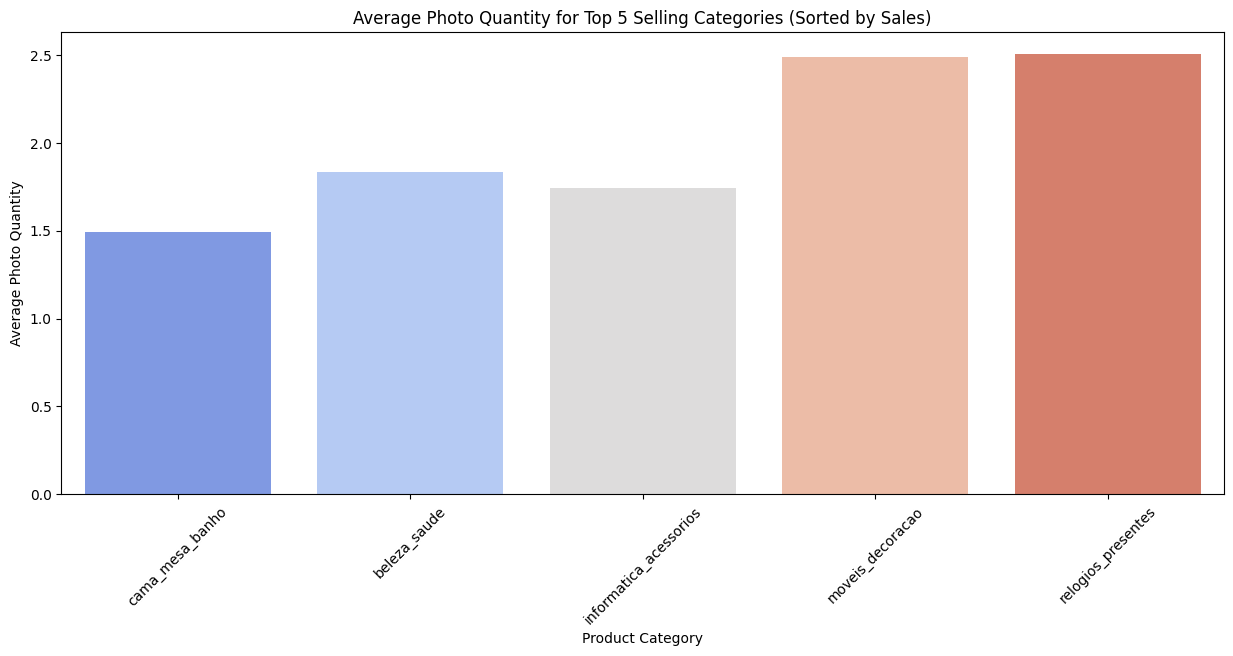

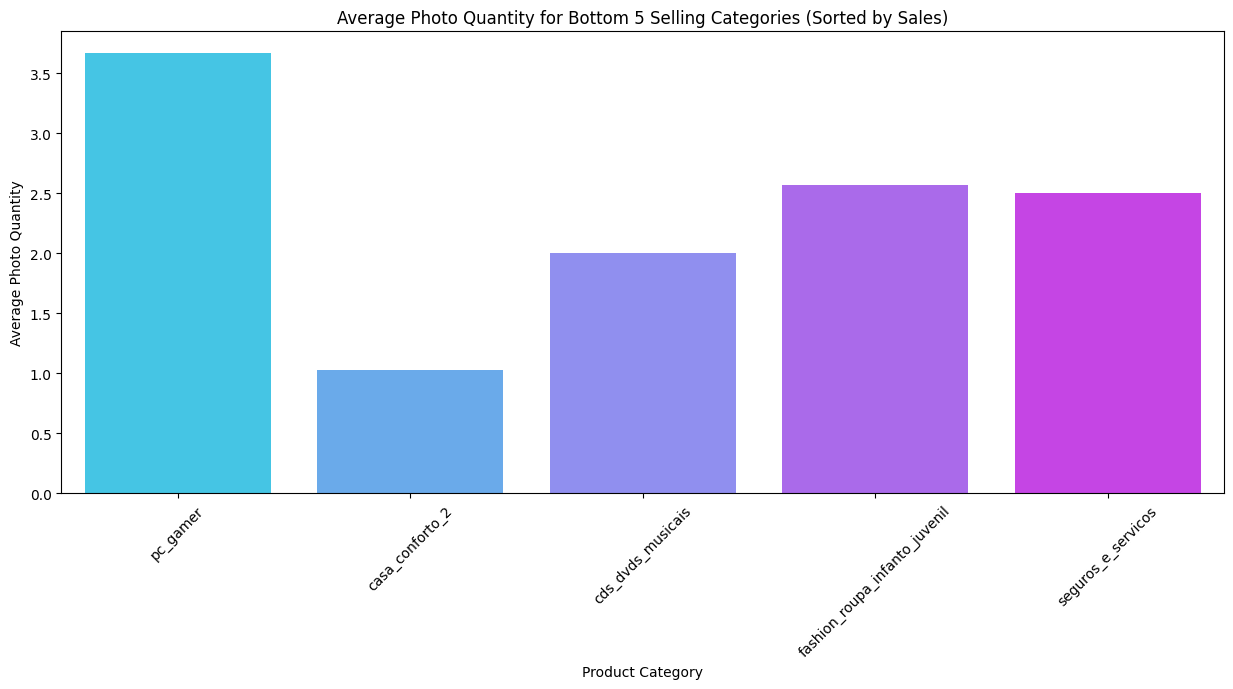

In [12]:
# Analysis 3
# Aggregate the data to find the average photo quantity for each category
avg_photo_top_bottom_categories = cleaned_df.groupby('product_category_name')['product_photos_qty'].mean().reset_index()

# Filter for the top 5 and bottom 5 categories
avg_photo_top_5_categories = avg_photo_top_bottom_categories[avg_photo_top_bottom_categories['product_category_name'].isin(top_5_categories['product_category_name'])]
avg_photo_bottom_5_categories = avg_photo_top_bottom_categories[avg_photo_top_bottom_categories['product_category_name'].isin(bottom_5_categories['product_category_name'])]

# Merge with the sales data for sorting
avg_photo_top_5_categories_sorted = pd.merge(avg_photo_top_5_categories, top_5_categories, on='product_category_name').sort_values(by='payment_value', ascending=False)
avg_photo_bottom_5_categories_sorted = pd.merge(avg_photo_bottom_5_categories, bottom_5_categories, on='product_category_name').sort_values(by='payment_value', ascending=False)

# Plotting for Top 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='product_photos_qty', data=avg_photo_top_5_categories_sorted, palette="coolwarm")
plt.title('Average Photo Quantity for Top 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Average Photo Quantity')
plt.xticks(rotation=45)
plt.show()

# Plotting for Bottom 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='product_photos_qty', data=avg_photo_bottom_5_categories_sorted, palette="cool")
plt.title('Average Photo Quantity for Bottom 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Average Photo Quantity')
plt.xticks(rotation=45)
plt.show()

C:\Users\Keembo\AppData\Local\Temp\ipykernel_260292\458344774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_top_5_categories['order_purchase_year_month'] = growth_top_5_categories['order_purchase_year_month'].astype(str)
C:\Users\Keembo\AppData\Local\Temp\ipykernel_260292\458344774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_bottom_5_categories['order_purchase_year_month'] = growth_bottom_5_categories['order_purchase_year_month'].astype(str)


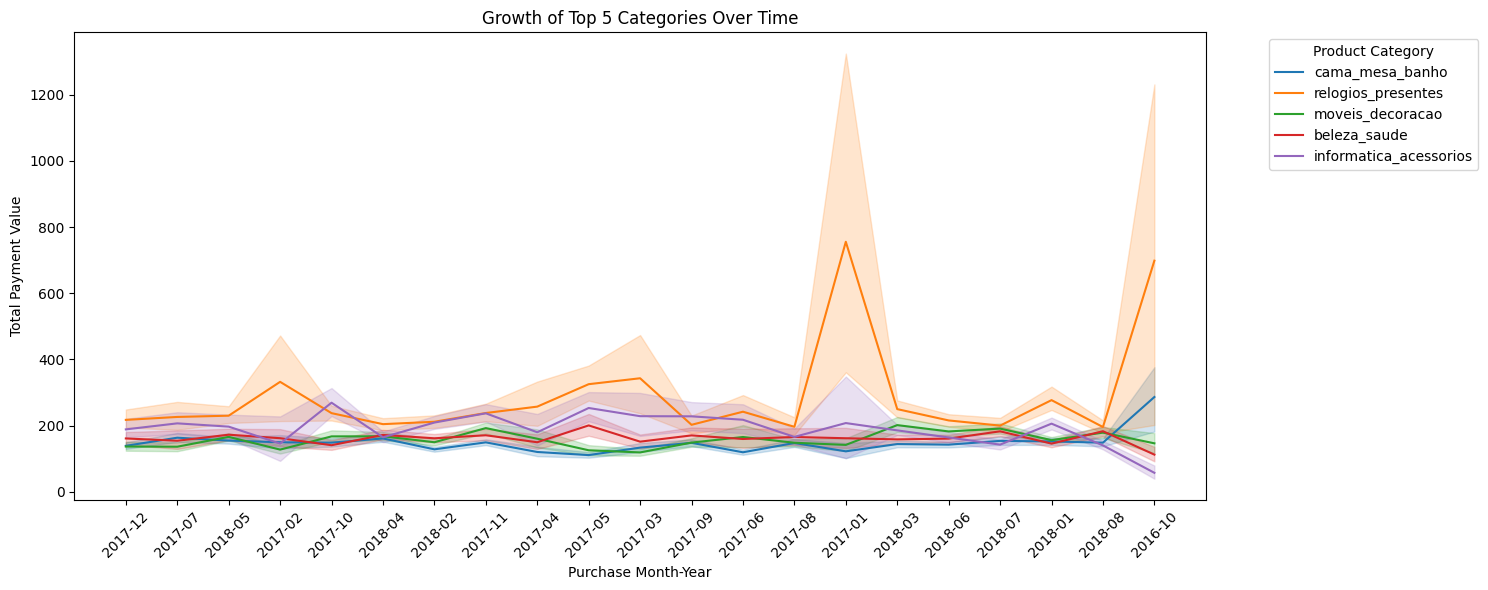

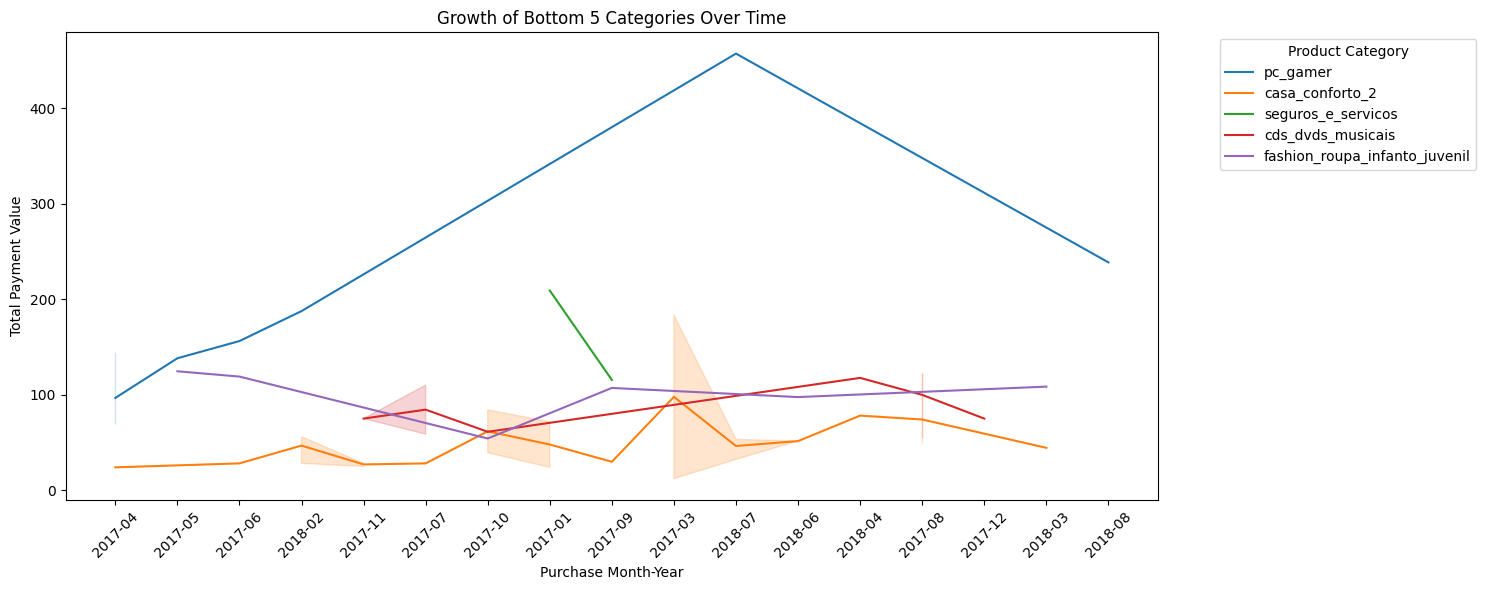

In [13]:
# Analysis 4
# Aggregate the sales data for the top 5 and bottom 5 categories by month-year
growth_top_5_categories = cleaned_df[cleaned_df['product_category_name'].isin(top_5_categories['product_category_name'])]
growth_bottom_5_categories = cleaned_df[cleaned_df['product_category_name'].isin(bottom_5_categories['product_category_name'])]

# Changing the data type for 'order_purchase_year_month' for plotting
growth_top_5_categories['order_purchase_year_month'] = growth_top_5_categories['order_purchase_year_month'].astype(str)
growth_bottom_5_categories['order_purchase_year_month'] = growth_bottom_5_categories['order_purchase_year_month'].astype(str)

# Plotting for Top 5 Categories
plt.figure(figsize=(15, 6))
sns.lineplot(x='order_purchase_year_month', y='payment_value', hue='product_category_name', data=growth_top_5_categories)
plt.title('Growth of Top 5 Categories Over Time')
plt.xlabel('Purchase Month-Year')
plt.ylabel('Total Payment Value')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting for Bottom 5 Categories
plt.figure(figsize=(15, 6))
sns.lineplot(x='order_purchase_year_month', y='payment_value', hue='product_category_name', data=growth_bottom_5_categories)
plt.title('Growth of Bottom 5 Categories Over Time')
plt.xlabel('Purchase Month-Year')
plt.ylabel('Total Payment Value')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

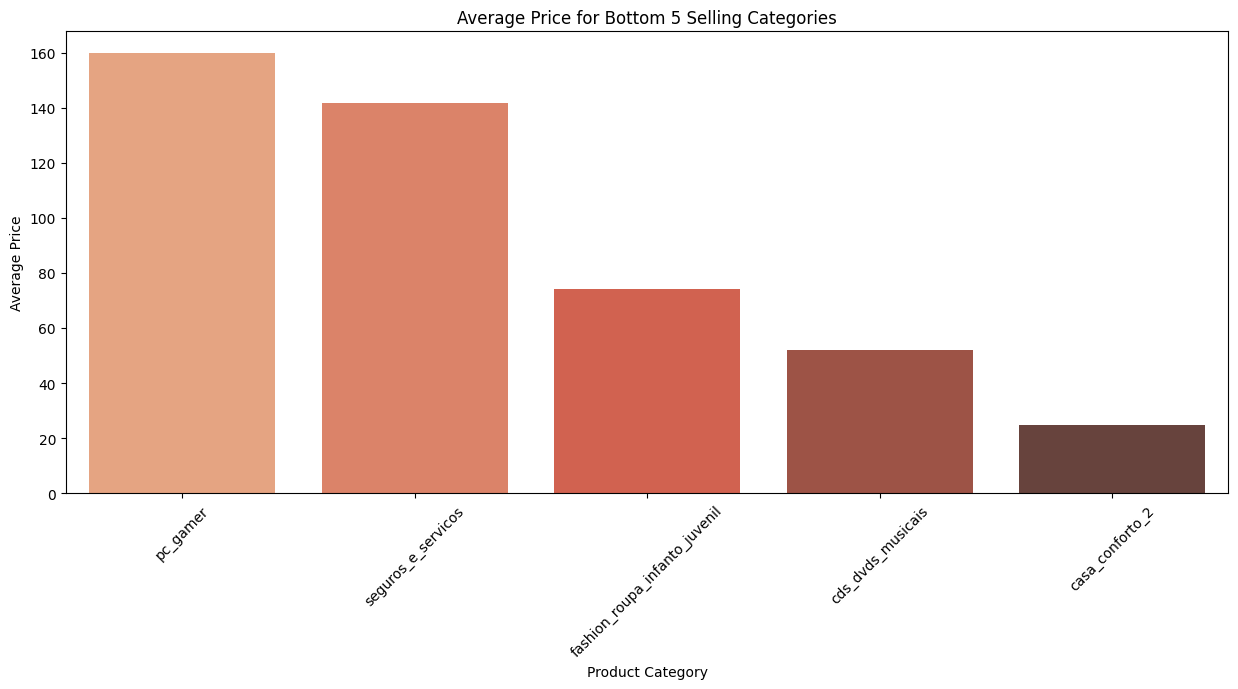

In [15]:
# Analysis 5
# Calculate the average price for the bottom 5 selling categories
avg_price_bottom_5_categories = cleaned_df[cleaned_df['product_category_name'].isin(bottom_5_categories['product_category_name'])]
avg_price_bottom_5_categories = avg_price_bottom_5_categories.groupby('product_category_name')['price'].mean().reset_index()

# Sort by the average price
avg_price_bottom_5_categories_sorted = avg_price_bottom_5_categories.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='price', data=avg_price_bottom_5_categories_sorted, palette="OrRd_d")
plt.title('Average Price for Bottom 5 Selling Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

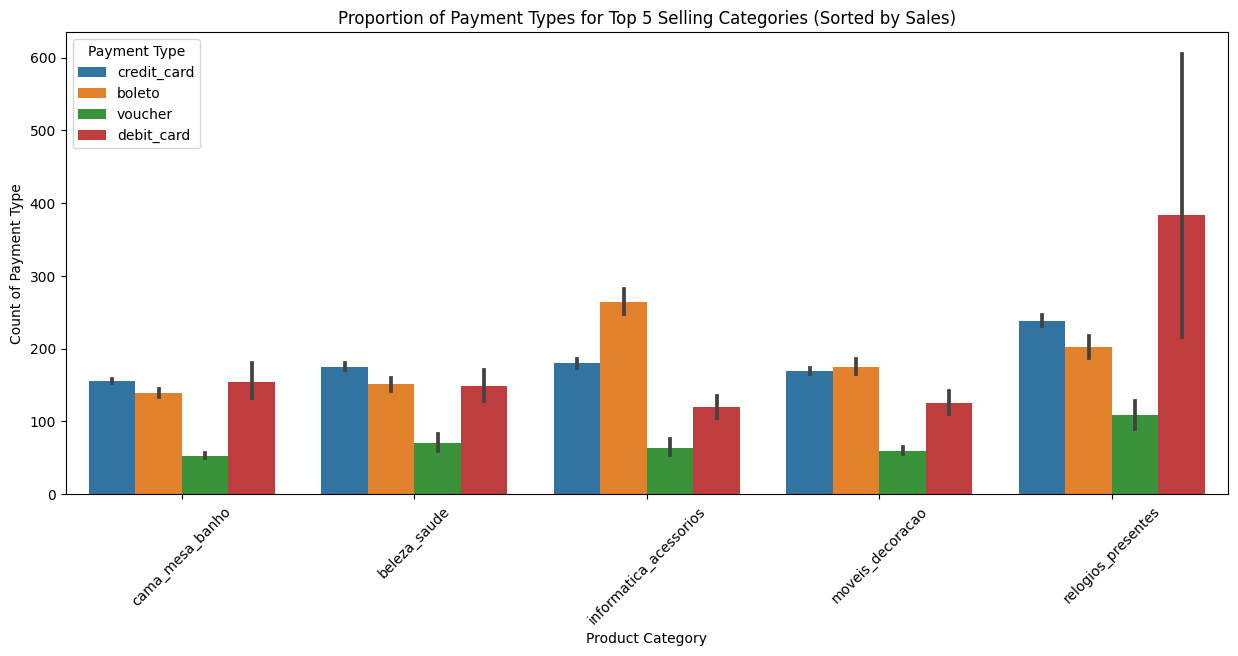

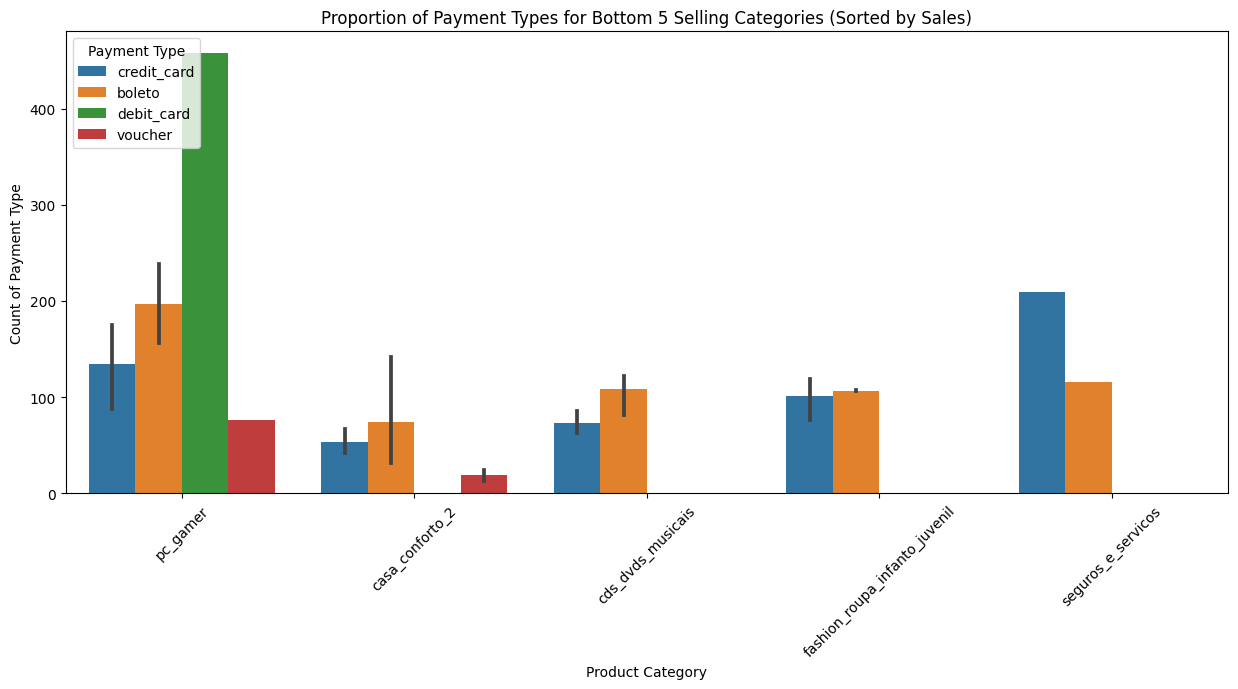

In [14]:
# Analysis 6
# Filter for the top 5 and bottom 5 categories
payment_type_top_5_categories = cleaned_df[cleaned_df['product_category_name'].isin(top_5_categories['product_category_name'])]
payment_type_bottom_5_categories = cleaned_df[cleaned_df['product_category_name'].isin(bottom_5_categories['product_category_name'])]

# Merge with sorted data before
payment_type_proportion_top_5_sorted = payment_type_top_5_categories.merge(top_5_categories, on='product_category_name')
payment_type_proportion_bottom_5_sorted = payment_type_bottom_5_categories.merge(bottom_5_categories, on='product_category_name')

# Plotting for Top 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value_x', hue='payment_type', data=payment_type_proportion_top_5_sorted.sort_values('payment_value_y', ascending=False))
plt.title('Proportion of Payment Types for Top 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Count of Payment Type')
plt.xticks(rotation=45)
plt.legend(title='Payment Type')
plt.show()

# Plotting for Bottom 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value_x', hue='payment_type', data=payment_type_proportion_bottom_5_sorted.sort_values('payment_value_y', ascending=False))
plt.title('Proportion of Payment Types for Bottom 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Count of Payment Type')
plt.xticks(rotation=45)
plt.legend(title='Payment Type')
plt.show()




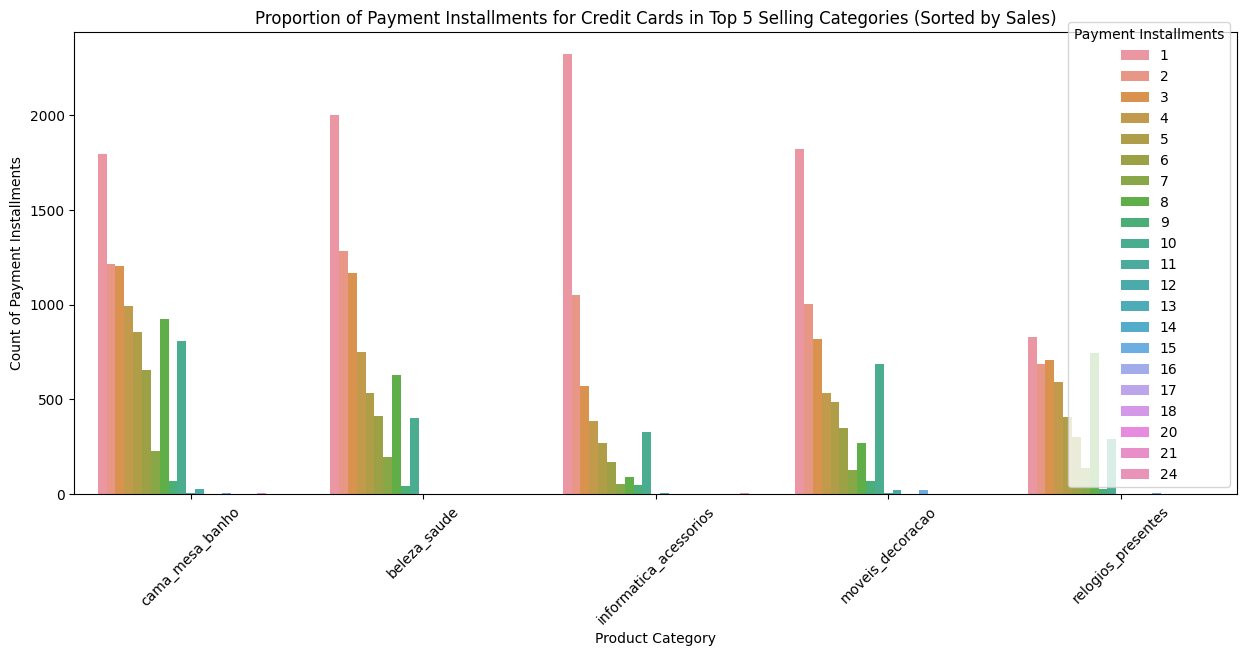

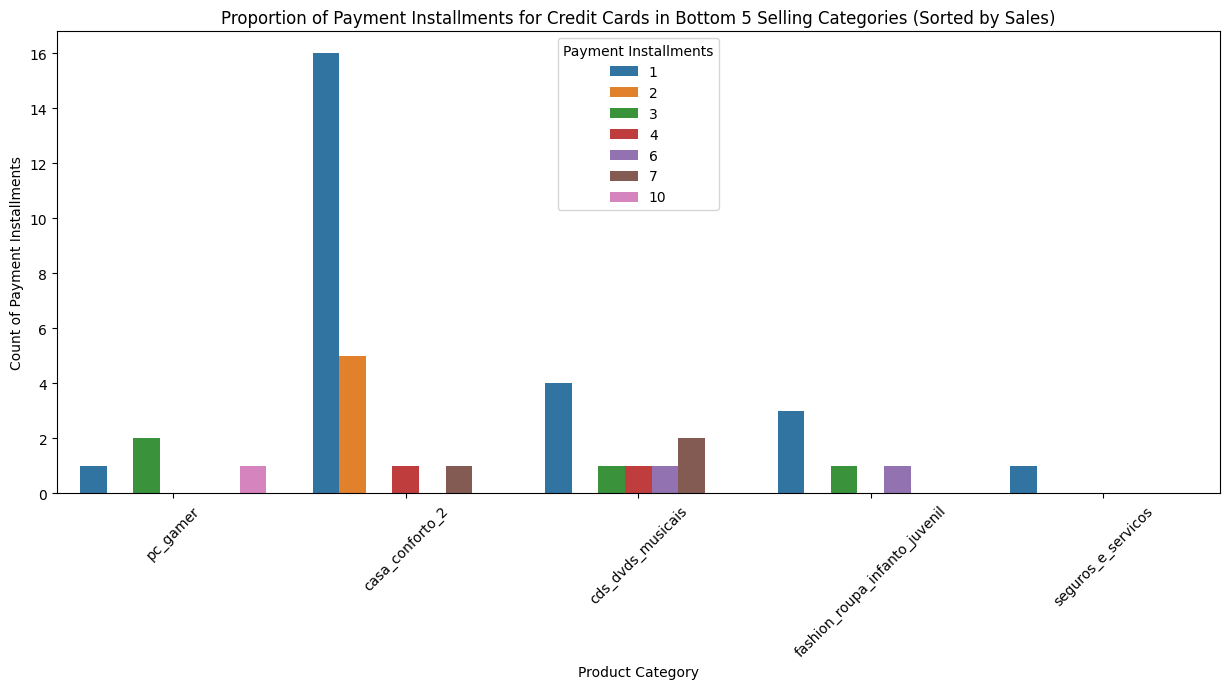

In [16]:
# Analysis 7
# Filter data for credit card payments
credit_card_top_5_categories = payment_type_top_5_categories[payment_type_top_5_categories['payment_type'] == 'credit_card']
credit_card_bottom_5_categories = payment_type_bottom_5_categories[payment_type_bottom_5_categories['payment_type'] == 'credit_card']

# Aggregate the data to find the proportion of payment installments
installment_proportion_top_5 = credit_card_top_5_categories.groupby(['product_category_name', 'payment_installments'])['payment_value'].count().reset_index()
installment_proportion_bottom_5 = credit_card_bottom_5_categories.groupby(['product_category_name', 'payment_installments'])['payment_value'].count().reset_index()

# Merge with sorted data before
installment_proportion_top_5_sorted = installment_proportion_top_5.merge(top_5_categories, on='product_category_name')
installment_proportion_bottom_5_sorted = installment_proportion_bottom_5.merge(bottom_5_categories, on='product_category_name')

# Plotting for Top 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value_x', hue='payment_installments', data=installment_proportion_top_5_sorted.sort_values('payment_value_y', ascending=False))
plt.title('Proportion of Payment Installments for Credit Cards in Top 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Count of Payment Installments')
plt.xticks(rotation=45)
plt.legend(title='Payment Installments')
plt.show()

# Plotting for Bottom 5 Categories
plt.figure(figsize=(15, 6))
sns.barplot(x='product_category_name', y='payment_value_x', hue='payment_installments', data=installment_proportion_bottom_5_sorted.sort_values('payment_value_y', ascending=False))
plt.title('Proportion of Payment Installments for Credit Cards in Bottom 5 Selling Categories (Sorted by Sales)')
plt.xlabel('Product Category')
plt.ylabel('Count of Payment Installments')
plt.xticks(rotation=45)
plt.legend(title='Payment Installments')
plt.show()